<a href="https://colab.research.google.com/github/gulabpatel/Recommendation_System/blob/main/01_Recommendation_system_YouTube_DL_Embedding_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Blog : https://data-flair.training/blogs/youtube-video-recommendation-system-ml/

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
os.chdir('/content/drive/MyDrive/Dataset')

In [4]:
!pwd

/content/drive/MyDrive/Dataset


Commented out IPython magic to ensure Python compatibility.<br>
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from copy import deepcopy

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
data_path = 'ml-100k/'

In [8]:
id_val = 1
num_users = 943 
num_items = 1682

In [9]:
train_dataframe = pd.read_csv(f'{data_path}u{id_val}.base',sep='\t',header=None)
train_dataframe.columns = ['user_id','item_id','rating','ts']
train_dataframe['user_id'] = train_dataframe['user_id'] -1 
train_dataframe['item_id'] = train_dataframe['item_id'] -1
valid_df = pd.read_csv(f'{data_path}u{id_val}.test',sep='\t',header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1 
valid_df['item_id'] = valid_df['item_id'] -1
train_dataframe.shape, valid_df.shape

((80000, 4), (20000, 4))

In [10]:
train_usrs = train_dataframe.user_id.unique()
vald_usrs = valid_df.user_id.unique()
len(train_usrs),len(vald_usrs)

(943, 459)

In [11]:
train_itms = train_dataframe.item_id.unique()
vald_itms = valid_df.item_id.unique()
len(train_itms),len(vald_itms)

(1650, 1410)

In [12]:
class CollabDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32, device = device)
        
    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])
    def __len__(self):
        return(self.user_tensor.shape[0])

In [13]:
batch_size = 2000
train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
len(train_dataset),len(valid_dataset),len(train_dataloader),len(valid_dataloader)
train_dataset[:3]

(tensor([0, 0, 0]), tensor([0, 1, 2]), tensor([5., 3., 4.]))

In [15]:
next(iter(train_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[tensor([537, 746, 737,  ..., 458,  41, 424]),
 tensor([ 49, 653, 194,  ..., 270, 940,  31]),
 tensor([5., 5., 4.,  ..., 4., 4., 3.])]

In [16]:
class ConcatNet(nn.Module):
    def __init__(self, config):
        super(ConcatNet, self).__init__()
        #hyperparameters
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.emb_size = config['emb_size']
        self.emb_droupout = config['emb_droupout']
        self.fc_layer_sizes = config['fc_layer_sizes']
        self.dropout = config['dropout']
        self.out_range = config['out_range']

        #embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.emb_size),
            nn.Dropout(p=self.emb_droupout))

        #fully-connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_layer_sizes[:-1], self.fc_layer_sizes[1:], self.dropout):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_layer_sizes[-1], out_features=1)
    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.out_range[1] - self.out_range[0]) + self.out_range[0]
        return(x)

In [17]:
config = {
    'num_users':943, 
    'num_items':1682, 
    'emb_size':50, 
    'emb_droupout': 0.05, 
    'fc_layer_sizes': [100, 512, 256], 
    'dropout': [0.7,0.35], 
    'out_range': [0.8,5.2]} 
model = ConcatNet(config)
model

ConcatNet(
  (emb_user): Sequential(
    (0): Embedding(943, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (emb_item): Sequential(
    (0): Embedding(1682, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
  )
  (head): Linear(in_features=256, out_features=1, bias=True)
)

In [18]:
batch_size = 2000 
learning_rate = 1e-2 
weight_decay = 5e-1 
num_epoch = 100 
reduce_learning_rate = 1 
early_stoping = 5 

In [19]:
learning_rates = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

In [20]:
train_dataset = CollabDataset(train_dataframe)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataset = CollabDataset(valid_df)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
model = ConcatNet(config)
criterion = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999), weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-3,
                                                       patience=reduce_learning_rate, min_lr=learning_rate/10)

In [22]:
for e in tqdm_notebook(range(num_epoch)): 
    model.train()
    train_loss = 0
    for u,i,r in train_dataloader:
        r_pred = model(u,i)
        r = r[:,None]
        
        loss = criterion(r_pred,r)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        current_learning_rate=optim.param_groups[0]["lr"]
        train_loss+= loss.detach().item()
    #current_learning_rate = scheduler.optimizer.param_groups[0]['learning_rate']
    #current_learning_rate = scheduler.step(loss)
    learning_rates.append(current_learning_rate)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dataloader:
        r_pred = model(u,i)
        r = r[:,None]
        loss = criterion(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_dataset)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_learning_rate}')
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1
    if no_improvements >= early_stoping:
        print(f'early stopping after epoch {e}')
        break
    
    scheduler.step(valid_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 Train loss: 1.3727562622070313; Valid loss: 1.196092431640625; Learning rate: 0.01
Epoch 1 Train loss: 1.0914699295043946; Valid loss: 1.0638611267089844; Learning rate: 0.01
Epoch 2 Train loss: 0.9891981674194336; Valid loss: 0.9875889526367188; Learning rate: 0.01
Epoch 3 Train loss: 0.9276249069213868; Valid loss: 0.9392919067382812; Learning rate: 0.01
Epoch 4 Train loss: 0.8989069580078125; Valid loss: 0.9237121276855469; Learning rate: 0.01
Epoch 5 Train loss: 0.8832414535522461; Valid loss: 0.9138063293457032; Learning rate: 0.01
Epoch 6 Train loss: 0.8745560012817383; Valid loss: 0.9235019287109375; Learning rate: 0.01
Epoch 7 Train loss: 0.8625772781372071; Valid loss: 0.9062754577636719; Learning rate: 0.01
Epoch 8 Train loss: 0.8544833129882813; Valid loss: 0.9047684204101563; Learning rate: 0.01
Epoch 9 Train loss: 0.8461960891723633; Valid loss: 0.8911216857910156; Learning rate: 0.01
Epoch 10 Train loss: 0.8335615768432617; Valid loss: 0.8798098754882813; Learning

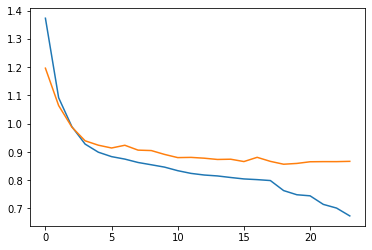

In [23]:
plt.plot(train_losses)
plt.plot(valid_losses)